In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings("ignore")

In [30]:
def generate_vehicle_sequence(N, target_percentage_ones=0.7):
    sequence_length = N

    count_ones = int(target_percentage_ones * sequence_length)
    count_zeros = sequence_length - count_ones

    random_sequence = [1] * count_ones + [0] * count_zeros

    # Shuffle the sequence to make it random
    random.shuffle(random_sequence)

    percentage_ones = (count_ones / sequence_length)

    return random_sequence, percentage_ones

In [31]:
def API(list_ = []):

    if not(np.any(list_)):
        return 1
    else:

        result = smt.stattools.acf(list_,adjusted=True)[1]

        return result

In [32]:
def pair_counting(list_=[]):
    pairs = np.zeros([2,2])
    for i in range(len(list_)-1):
        for j in range(0,2):
            for k in range(0, 2):
                if list_[i] == j and list_[i+1] == k:
                    pairs[j,k] = pairs[j,k]+1

    return pairs

In [33]:
def flow_calculation(n00,n01,n10,n11,h_HV_HV,h_HV_AV,h_AV_HV,h_AV_AV):
    q = 3600*(n00+n01+n10+n11)/(h_HV_HV*n00+h_HV_AV*n01+h_AV_HV*n10+h_AV_AV*n11)
    return q

In [34]:
def calculate_set_data_parallel(param_set):
    h_HV_HV, h_AV_HV, h_HV_AV, h_AV_AV = param_set
    N = 100
    Prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    data = pd.DataFrame(columns=['list', 'P', 'h_HV_HV', 'h_AV_HV', 'h_HV_AV', 'h_AV_AV', 'API', 'N00', 'N11', 'N10', 'N01', 'flow_real'])

    for num in range(0, 10001):
        for Proportion in Prob:
            list_ = generate_vehicle_sequence(N, Proportion)
            P_CAV = list_[1]
            rho = API(list_[0])
            N00 = pair_counting(list_[0])[0][0]
            N11 = pair_counting(list_[0])[1][1]
            N10 = pair_counting(list_[0])[1][0]
            N01 = pair_counting(list_[0])[0][1]
            q_real = flow_calculation(N00, N01, N10, N11, h_HV_HV, h_HV_AV, h_AV_HV, h_AV_AV)
            new_row = {'list': list_[0], 'N': N, 'P': P_CAV, 'h_HV_HV': h_HV_HV, 'h_AV_HV': h_AV_HV, 'h_HV_AV': h_HV_AV, 'h_AV_AV': h_AV_AV, 'API': rho, 'N00': N00, 'N11': N11, 'N10': N10, 'N01': N01, 'flow_real': q_real}
            data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

    Set = data[['P', 'API', 'flow_real', 'h_HV_HV', 'h_AV_HV', 'h_HV_AV', 'h_AV_AV']]
    Set['API'] = Set['API'].round(1)
    Set = Set.groupby(['P', 'API']).mean()

    return Set

In [35]:
param_sets = [(1.6, 1.5, 1.7, 1.0),
 (1.3, 1.3, 1.3, 0.9),
 (1.0, 1.2, 1.1, 0.8),
 (1.7, 1.4, 1.8, 0.8)]

# Parallelize the execution
with ProcessPoolExecutor() as executor:
    all_sets_data_parallel = list(executor.map(calculate_set_data_parallel, param_sets))

# Combine the results
all_data_df_parallel = pd.concat([pd.DataFrame(data).assign(param_set=f"Set {i + 1}") for i, data in enumerate(all_sets_data_parallel)], names=['param_set', 'P', 'API']).reset_index()

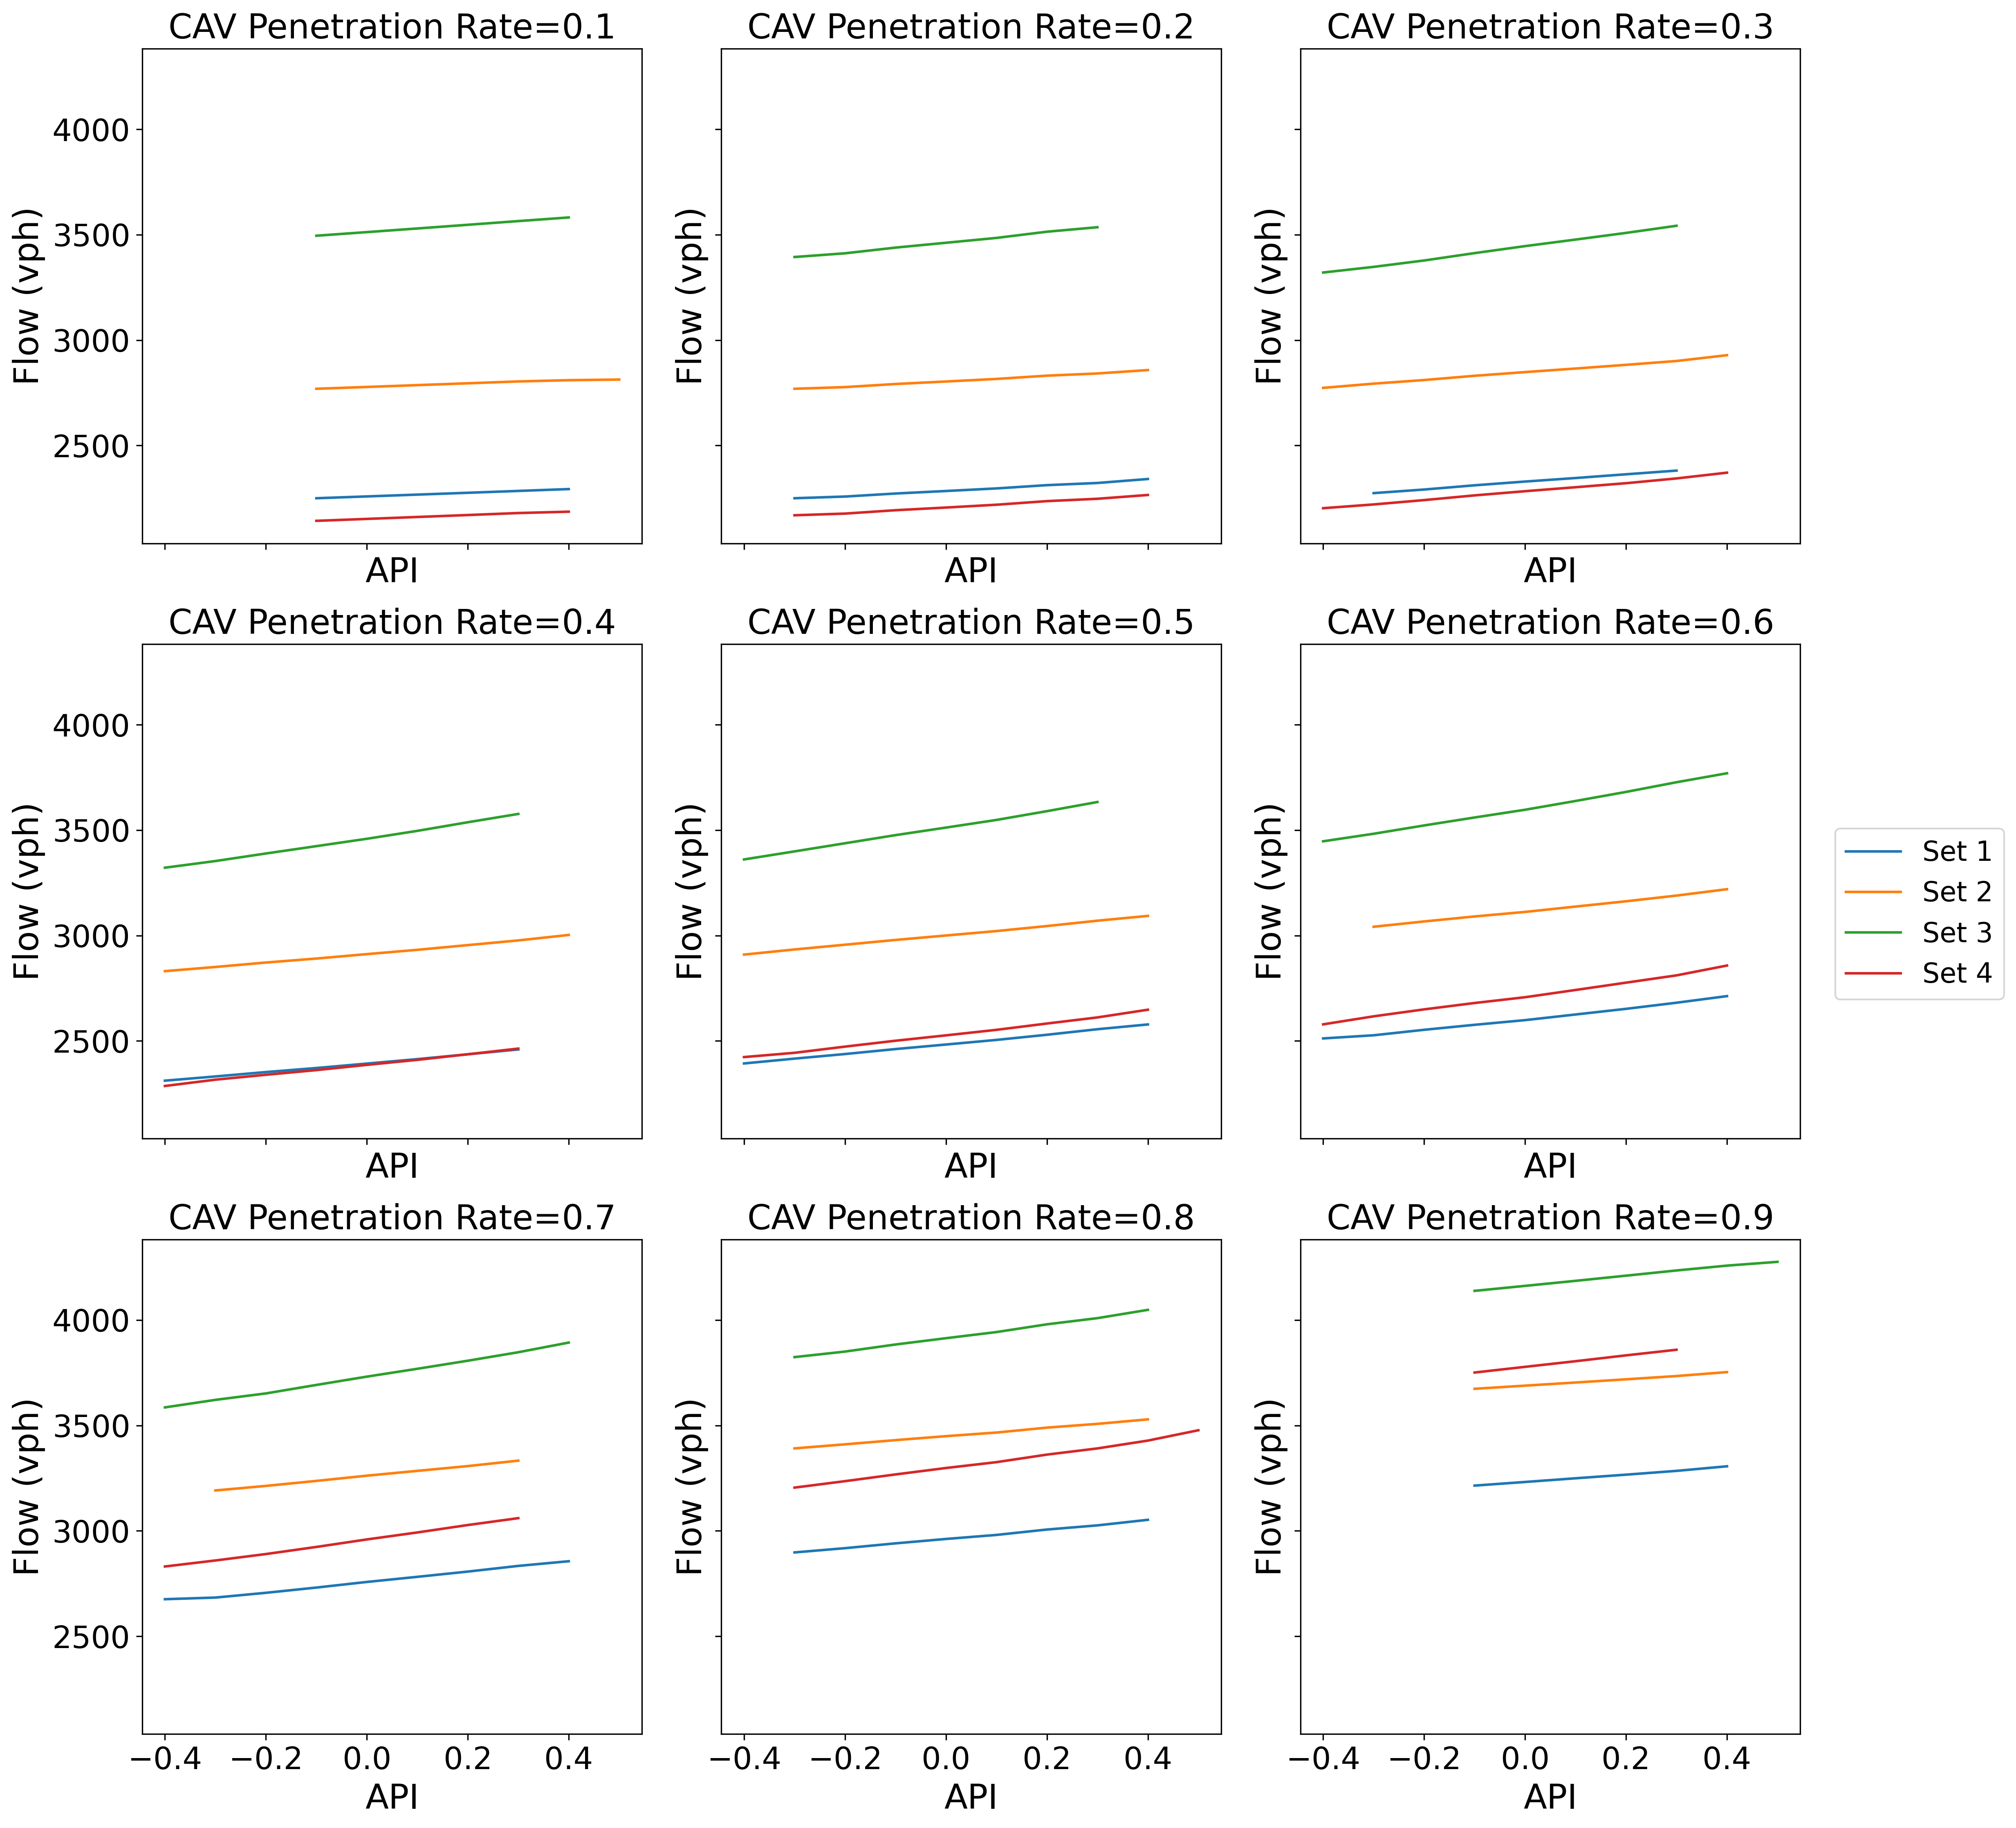

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True, dpi=300)

# Loop through each subplot
for i, P in enumerate([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    #row_index, col_index = divmod(i, 3)  # Convert 1D index to 2D index
    row_index = i // 3
    col_index = i % 3
    ax = axes[row_index, col_index]  # Use row and column indices to access each subplot

    # Filter data for the specific P and IPI
    filtered_data = all_data_df_parallel[(all_data_df_parallel['P'] == P)]

    # Loop through each param_set and plot the curve
    for param_set, data in filtered_data.groupby('param_set'):
        ax.plot(data['API'], data['flow_real'], label=param_set)

    ax.set_title(f'CAV Penetration Rate={P}', fontsize=20)
    ax.set_xlabel('API', fontsize=20)
    ax.set_ylabel('Flow (vph)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

    plt.locator_params(axis='x', integer=True)

# Create a legend outside the subplots on the right
handles, labels = axes[0, 0].get_legend_handles_labels()  # Use indices of any subplot for legend
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.1, 0.5), prop={'size': 16})

plt.tight_layout()
plt.show()